In [1]:
import os
import cv2
import numpy as np
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import math
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [2]:
# --- Configuration ---
DATA_DIR = './data'
N_CLUSTERS = 10000    # BoVW 词典大小
MAX_KP = 100         # 每张图最大关键点数
PATCH_SIZE = 16     # 描述子 patch 大小
INTEREST_METHOD = 'DoG'  # 可选: 'DoG', 'Harris', 'LoG'
EPOCHS = 50
LR = 1e-3

In [3]:
# --- Setup MPS device ---
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

In [4]:
# --- 1. Interest Point Detection ---
def detect_interest_points(gray, method='DoG', threshold=5):
    if method == 'DoG':
        # Define multiple sigma values for Gaussian blur
        num_octaves=3 # the level of the image pyramid
        scales_per_octave=3 # the number of scales per octave
        sigma0=1.6 # otiginal sigma value
        
        keypoints = []
        k = 2 ** (1 / scales_per_octave)  # 每层之间的尺度倍增因子
        
        # form the 0th octave to num_octaves-1 octaves
        for octave in range(num_octaves):
            # 1) create the base image for the current octave
            if octave == 0:
                base = gray.copy()
            else:
                # 下采样前一个 octave 的 base
                base = cv2.pyrDown(prev_base)
            
            # save the current base for the next octave
            prev_base = base
            # calculate the size of the base image
            h, w = base.shape
            
            # 2) 构建本 octave 的 Gaussian 金字塔
            #    需要做 (scales_per_octave + 3) 层，以便产生 scales_per_octave+2 个 DoG 层
            sigmas = [sigma0 * (k ** (i + octave*scales_per_octave)) for i in range(scales_per_octave + 3)]
            gaussians = [cv2.GaussianBlur(base, (0,0), sigmaX=s) for s in sigmas]
            
            # 3) 计算 DoG 图层
            dogs = []
            for i in range(len(gaussians)-1):
                diff = gaussians[i+1].astype(np.float32) - gaussians[i].astype(np.float32)
                dogs.append(diff)
            
            # 4) 在空间 + 尺度域寻找极值点
            #    只从第 1 层到倒数第 2 层做比较，因为要用前后层做上下尺度比较
            for i in range(1, len(dogs)-1):
                # the three layers to compare
                prev_d, curr_d, next_d = dogs[i-1], dogs[i], dogs[i+1]

                # max_spat and min_spat are masks of the same size as curr_d
                # 空间极值：用形态学膨胀/腐蚀检测局部极大/极小值
                # 对 curr_d 做形态学膨胀（dilation），相当于每个像素点被它 3×3 邻域内的最大值取代。
                #curr_d 在每个像素的 3×3 邻域内取最大值，输出也是一个 (H, W) 的数组——max_spat[y, x] 就是 curr_d 在 (y, x) 周围那 9 个点里的最大值。
                max_spat = cv2.dilate(curr_d, np.ones((3,3),np.uint8))
                # 做腐蚀（erosion），相当于每个像素点被邻域内的最小值取代。
                min_spat = cv2.erode( curr_d, np.ones((3,3),np.uint8))
                
                # 跨尺度极值：要比前一 DoG 和后一 DoG 都大（或都小）
                mask_max = (curr_d == max_spat) & (curr_d > prev_d) & (curr_d > next_d) & (np.abs(curr_d) > threshold)
                mask_min = (curr_d == min_spat) & (curr_d < prev_d) & (curr_d < next_d) & (np.abs(curr_d) > threshold)
                
                # Find all coordinates of the points that satisfy the conditions
                coords = np.vstack((np.argwhere(mask_max), np.argwhere(mask_min)))

                # 5) 将坐标映射回原图尺度并创建 KeyPoint
                for y, x in coords:
                    # 因为后面可能 downsample 了，需要乘回 2**octave
                    scale = (2 ** octave)

                    kp = cv2.KeyPoint(float(x*scale), float(y*scale), size=PATCH_SIZE * scale)
                    keypoints.append(kp)
                    
        # 最后按响应或数量截断
        keypoints = sorted(keypoints, key=lambda kp: kp.response if hasattr(kp, 'response') else 1.0,
                        reverse=True)
        return keypoints[:MAX_KP]
    elif method == 'Harris':
        harris = cv2.cornerHarris(gray.astype(np.float32), 2, 3, 0.04)
        coords = np.argwhere(harris > threshold * harris.max())
    elif method == 'LoG':
        log = cv2.Laplacian(gray, cv2.CV_64F)
        coords = np.argwhere(np.abs(log) > threshold)
    else:
        sift = cv2.SIFT_create()
        kps = open_kps = sift.detect(gray, None)
        # raise ValueError('Unsupported method')
    # Create keypoints and limit count
    return kps[:MAX_KP]

In [5]:
# --- 2. Compute Custom SIFT-like Descriptor ---
def compute_custom_sift_descriptor(gray, keypoints, patch_size=PATCH_SIZE):
    # Compute gradients once
    grad_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    mag = cv2.magnitude(grad_x, grad_y)
    ori = cv2.phase(grad_x, grad_y, angleInDegrees=True)

    descriptors = []
    half = patch_size // 2
    h, w = gray.shape

    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        # boundary check
        if x-half < 0 or y-half < 0 or x+half >= w or y+half >= h:
            continue
        # extract full patch
        mag_full = mag[y-half:y+half, x-half:x+half]
        ori_full = ori[y-half:y+half, x-half:x+half]
        # 1) Orientation assignment: build 36-bin histogram over full patch
        hist8, bin_edges = np.histogram(
            ori_full.ravel(), bins=8, range=(0,360), weights=mag_full.ravel()
        )
        # main orientation is center of max bin
        max_idx = np.argmax(hist8)
        main_ori = (bin_edges[max_idx] + bin_edges[max_idx+1]) / 2.0
        # normalize full patch orientations relative to main orientation
        ori_full = (ori_full - main_ori + 360) % 360

        # slice into subregions and build descriptor
        desc = []
        for i in range(4):
            for j in range(4):
                sub_mag = mag_full[i*4:(i+1)*4, j*4:(j+1)*4].ravel()
                sub_ori = ori_full[i*4:(i+1)*4, j*4:(j+1)*4].ravel()
                # 2) histogram on aligned orientations
                hsub, _ = np.histogram(sub_ori, bins=8, range=(0,360), weights=sub_mag)
                desc.extend(hsub)
        desc = np.array(desc, dtype=np.float32)
        desc /= (np.linalg.norm(desc) + 1e-7)
        descriptors.append(desc)

    return np.array(descriptors) if descriptors else None

In [6]:
# --- 3. Load CIFAR-10 ---
# transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([
    # 先把 32×32 放大到 128×128
    transforms.Resize((128, 128), interpolation=InterpolationMode.BICUBIC),

    # # 再做常见的数据增强（可按需打开/调整顺序）
    # transforms.RandomCrop(120, padding=4),           # 随机裁剪到 120×120 并 pad
    # transforms.RandomHorizontalFlip(p=0.5),          # 随机水平翻转
    # transforms.ColorJitter(brightness=0.2,
    #                        contrast=0.2,
    #                        saturation=0.2,
    #                        hue=0.1),                  # 随机色相／亮度／对比度扰动

    # 转成 Tensor 并归一化到 [0,1]
    transforms.ToTensor(),

    # 再做标准化（CIFAR-10 通常用以下均值/方差）
    # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
    #                      std =[0.2470, 0.2435, 0.2616]),
])

trainset = CIFAR10(DATA_DIR, train=True, download=True, transform=transform)
testset  = CIFAR10(DATA_DIR, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


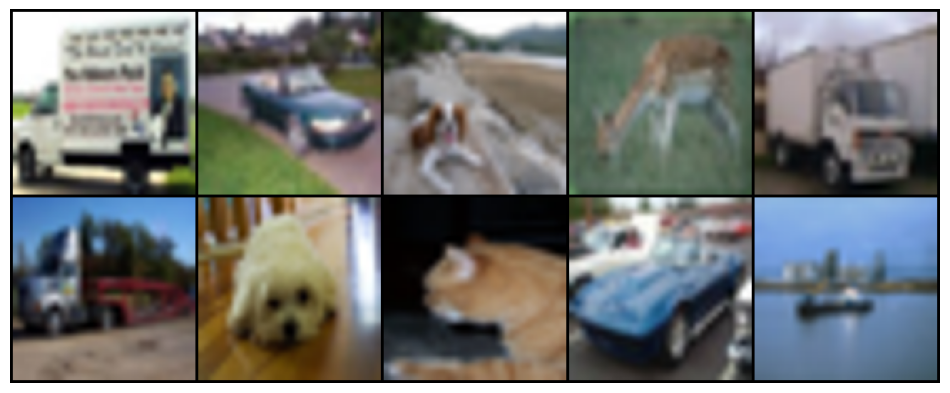

In [7]:
# 3. 准备逆标准化，以便可视化
# mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
# std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)
# inv_norm = transforms.Normalize((-mean/std).squeeze(), (1/std).squeeze())

indices = random.sample(range(len(trainset)), 10)
imgs = []
for idx in indices:
    img, _ = trainset[idx]      # 返回 (C,H,W) tensor
    # img = inv_norm(img)        # 逆归一化到 [0,1]
    # img = torch.clamp(img, 0, 1)
    imgs.append(img)

grid = make_grid(imgs, nrow=5, padding=2)
plt.figure(figsize=(12, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [8]:
# --- 4. Extract descriptors from training set ---
all_desc = []
img_desc_idx = []
train_labels = []
print('Extracting training descriptors...')
for img, label in tqdm(trainset, desc='Train images'):
    img_np = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    kps = detect_interest_points(gray, method=INTEREST_METHOD)
    des = compute_custom_sift_descriptor(gray, kps)
    if des is not None:
        all_desc.extend(des)
    img_desc_idx.append(len(all_desc))
    train_labels.append(label)
all_desc = np.vstack(all_desc)

Extracting training descriptors...


Train images: 100%|██████████| 50000/50000 [37:05<00:00, 22.46it/s]


In [9]:
# --- 5. Build visual vocabulary ---
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, batch_size=1000, verbose=1)
kmeans.fit(all_desc)

Init 1/1 with method k-means++
Inertia for init 1/1: 9244.576171875
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 1/416455: mean batch inertia: 0.2989022216796875
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 2/416455: mean batch inertia: 0.3175277099609375, ewa inertia: 0.3175277099609375
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 3/416455: mean batch inertia: 0.30919024658203126, ewa inertia: 0.3175237059531283
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 4/416455: mean batch inertia: 0.3139105224609375, ewa inertia: 0.31752197074731553
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 5/416455: mean batch inertia: 0.31012734985351564, ewa inertia: 0.3175184195329402
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 6/416455: mean batch inertia: 0.3100663452148438, ewa inertia: 0.3175148407269643
[MiniBatchKMeans] Reassigning 500 cluster centers.
Minibatch step 7/416455

MiniBatchKMeans(batch_size=1000, n_clusters=10000, verbose=1)

In [10]:
# --- 6. Build BoVW features for train ---
def build_bovw(descriptors):
    words = kmeans.predict(descriptors)
    hist, _ = np.histogram(words, bins=np.arange(N_CLUSTERS+1))
    return hist.astype(float) / (hist.sum() + 1e-7)

train_feats = []
start = 0
# for idx in img_desc_idx:
for idx in tqdm(img_desc_idx, desc='Building BoVW features'):
    end = idx
    if end - start > 0:
        train_feats.append(build_bovw(all_desc[start:end]))
    else:
        train_feats.append(np.zeros(N_CLUSTERS, dtype=float))
    start = end
train_feats = np.array(train_feats)
train_labels = np.array(train_labels)

Building BoVW features: 100%|██████████| 50000/50000 [01:48<00:00, 459.41it/s]


In [11]:
# --- 7. Extract BoVW features for test set ---
test_feats = []
test_labels = []
print('Extracting test BoVW features...')
for img, label in tqdm(testset, desc='Test images'):
    img_np = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    kps = detect_interest_points(gray, method=INTEREST_METHOD)
    des = compute_custom_sift_descriptor(gray, kps)
    if des is not None:
        hist = build_bovw(des)
    else:
        hist = np.zeros(N_CLUSTERS, dtype=float)
    test_feats.append(hist)
    test_labels.append(label)

test_feats = np.array(test_feats)
test_labels = np.array(test_labels)

Extracting test BoVW features...


Test images: 100%|██████████| 10000/10000 [08:01<00:00, 20.77it/s]


## Softmax

In [19]:
# --- 8. Train Softmax Regression (Logistic Regression) on MPS ---
# Prepare PyTorch tensors
X_train = torch.from_numpy(train_feats).float().to(device)
y_train = torch.from_numpy(train_labels).long().to(device)
X_test  = torch.from_numpy(test_feats).float().to(device)
y_test  = torch.from_numpy(test_labels).long().to(device)

# Define simple linear model
model = nn.Linear(N_CLUSTERS, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

print('Training Softmax Regression...')
for ep in range(1, EPOCHS+1):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if ep % 5 == 0:
        print(f'Epoch {ep}/{EPOCHS}, loss={loss.item():.4f}')

Training Softmax Regression...
Epoch 5/50, loss=2.3010
Epoch 10/50, loss=2.2989
Epoch 15/50, loss=2.2970
Epoch 20/50, loss=2.2951
Epoch 25/50, loss=2.2934
Epoch 30/50, loss=2.2918
Epoch 35/50, loss=2.2903
Epoch 40/50, loss=2.2890
Epoch 45/50, loss=2.2877
Epoch 50/50, loss=2.2866


In [20]:
# --- 9. Evaluate on test set ---
model.eval()
with torch.no_grad():
    preds = model(X_test).argmax(dim=1)
    acc = (preds == y_test).float().mean().item()
print(f'Test Accuracy: {acc:.4f}')
# Convert MPS tensor to CPU numpy for classification_report
preds_np = preds.cpu().numpy()
print(classification_report(test_labels, preds_np))

Test Accuracy: 0.3720
              precision    recall  f1-score   support

           0       0.37      0.24      0.29      1000
           1       0.43      0.42      0.43      1000
           2       0.37      0.22      0.27      1000
           3       0.33      0.11      0.17      1000
           4       0.34      0.32      0.33      1000
           5       0.34      0.38      0.36      1000
           6       0.36      0.60      0.45      1000
           7       0.35      0.42      0.38      1000
           8       0.35      0.50      0.42      1000
           9       0.47      0.51      0.49      1000

    accuracy                           0.37     10000
   macro avg       0.37      0.37      0.36     10000
weighted avg       0.37      0.37      0.36     10000



## SVM

In [14]:
# 1. 定义一个 Pipeline，把 StandardScaler 和 LinearSVC 串起来
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    LinearSVC(dual=False, max_iter=500, random_state=42, verbose=2))
])

# 2. 指定要搜索的超参数网格
param_grid = {
    'svc__C':    [1],
    'svc__tol':  [1e-4]
}

# 3. 构造 GridSearchCV：5 折交叉验证，使用所有 CPU 核心
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    n_jobs=-1, # 使用所有 CPU 核心
    verbose=2, # 输出详细信息
    scoring='accuracy'
)

# 4. 在训练集上搜索最佳超参
grid.fit(train_feats, train_labels)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)



Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]iter  1 act 3.135e+04 pre 3.084e+04 delta 8.730e-01 f 4.000e+04 |g| 8.396e+04 CG   6
iter  1 act 3.135e+04 pre 3.084e+04 delta 8.729e-01 f 4.000e+04 |g| 8.426e+04 CG   6
iter  1 act 3.134e+04 pre 3.084e+04 delta 8.718e-01 f 4.000e+04 |g| 8.421e+04 CG   6
iter  1 act 3.136e+04 pre 3.086e+04 delta 8.730e-01 f 4.000e+04 |g| 8.423e+04 CG   6
iter  1 act 3.136e+04 pre 3.085e+04 delta 8.730e-01 f 4.000e+04 |g| 8.391e+04 CG   6
iter  2 act 2.355e+03 pre 1.923e+03 delta 8.730e-01 f 8.655e+03 |g| 1.177e+04 CG  12
iter  2 act 2.426e+03 pre 1.976e+03 delta 8.729e-01 f 8.652e+03 |g| 1.180e+04 CG  12
iter  2 act 2.338e+03 pre 1.903e+03 delta 8.718e-01 f 8.660e+03 |g| 1.171e+04 CG  12
iter  2 act 2.415e+03 pre 1.962e+03 delta 8.730e-01 f 8.643e+03 |g| 1.176e+04 CG  12
iter  2 act 2.399e+03 pre 1.953e+03 delta 8.730e-01 f 8.638e+03 |g| 1.187e+04 CG  12
cg reaches trust region boundary
cg 

/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


iter 494 act 4.284e-05 pre 4.280e-05 delta 6.979e-05 f 2.211e+01 |g| 1.600e+00 CG   2
cg reaches trust region boundary
iter 442 act 6.933e-05 pre 8.808e-05 delta 6.552e-05 f 2.315e+01 |g| 3.540e+00 CG   3
cg reaches trust region boundary
[CV] END ..........................svc__C=1, svc__tol=0.0001; total time=93.5min
iter 485 act 3.561e-05 pre 4.462e-05 delta 5.109e-05 f 2.259e+01 |g| 1.802e+00 CG   2
iter 429 act 7.219e-05 pre 8.604e-05 delta 6.663e-05 f 2.185e+01 |g| 2.766e+00 CG   3
cg reaches trust region boundary
cg reaches trust region boundary
iter 495 act 6.104e-05 pre 6.463e-05 delta 8.624e-05 f 2.211e+01 |g| 1.788e+00 CG   2
cg reaches trust region boundary
iter 443 act 6.149e-05 pre 7.694e-05 delta 6.552e-05 f 2.315e+01 |g| 2.456e+00 CG   3
iter 486 act 4.372e-05 pre 4.690e-05 delta 5.109e-05 f 2.259e+01 |g| 1.879e+00 CG   2
cg reaches trust region boundary
iter 430 act 5.893e-05 pre 7.863e-05 delta 5.400e-05 f 2.185e+01 |g| 3.054e+00 CG   3
cg reaches trust region boundary


/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


cg reaches trust region boundary
cg reaches trust region boundary
cg reaches trust region boundary
[CV] END ..........................svc__C=1, svc__tol=0.0001; total time=93.6min
iter 492 act 4.584e-05 pre 4.802e-05 delta 4.601e-05 f 2.259e+01 |g| 2.177e+00 CG   3
iter 449 act 3.884e-05 pre 4.562e-05 delta 3.700e-05 f 2.315e+01 |g| 2.621e+00 CG   2
iter 436 act 5.555e-05 pre 7.522e-05 delta 6.454e-05 f 2.185e+01 |g| 2.336e+00 CG   3
cg reaches trust region boundary
cg reaches trust region boundary
cg reaches trust region boundary
iter 493 act 3.307e-05 pre 4.174e-05 delta 4.601e-05 f 2.259e+01 |g| 1.671e+00 CG   2
iter 450 act 4.100e-05 pre 4.096e-05 delta 5.587e-05 f 2.315e+01 |g| 1.834e+00 CG   2
cg reaches trust region boundary
iter 437 act 9.114e-05 pre 9.894e-05 delta 6.567e-05 f 2.185e+01 |g| 3.187e+00 CG   3
cg reaches trust region boundary
cg reaches trust region boundary
iter 494 act 4.006e-05 pre 4.291e-05 delta 4.842e-05 f 2.259e+01 |g| 1.761e+00 CG   2
iter 451 act 5.057e-

/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


iter 457 act 4.260e-05 pre 5.822e-05 delta 5.067e-05 f 2.315e+01 |g| 2.615e+00 CG   3
[CV] END ..........................svc__C=1, svc__tol=0.0001; total time=93.8min
iter 444 act 6.944e-05 pre 7.951e-05 delta 6.567e-05 f 2.185e+01 |g| 2.643e+00 CG   3
cg reaches trust region boundary
cg reaches trust region boundary
iter 458 act 4.733e-05 pre 5.885e-05 delta 5.067e-05 f 2.315e+01 |g| 2.627e+00 CG   2
iter 445 act 5.970e-05 pre 7.134e-05 delta 6.567e-05 f 2.185e+01 |g| 2.278e+00 CG   3
cg reaches trust region boundary
cg reaches trust region boundary
iter 459 act 4.058e-05 pre 5.455e-05 delta 4.227e-05 f 2.315e+01 |g| 2.741e+00 CG   3
cg reaches trust region boundary
iter 446 act 7.089e-05 pre 8.089e-05 delta 6.567e-05 f 2.185e+01 |g| 2.744e+00 CG   3
cg reaches trust region boundary
iter 460 act 4.104e-05 pre 5.044e-05 delta 4.227e-05 f 2.315e+01 |g| 2.381e+00 CG   2
cg reaches trust region boundary
iter 447 act 5.695e-05 pre 6.874e-05 delta 6.567e-05 f 2.185e+01 |g| 2.236e+00 CG   3


/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


iter 485 act 6.082e-05 pre 7.833e-05 delta 7.536e-05 f 2.185e+01 |g| 2.201e+00 CG   3
[CV] END ..........................svc__C=1, svc__tol=0.0001; total time=94.3min
cg reaches trust region boundary
iter 486 act 7.658e-05 pre 9.091e-05 delta 7.537e-05 f 2.185e+01 |g| 2.666e+00 CG   3
cg reaches trust region boundary
iter 487 act 6.365e-05 pre 8.140e-05 delta 7.537e-05 f 2.185e+01 |g| 2.238e+00 CG   3
cg reaches trust region boundary
iter 488 act 7.323e-05 pre 8.786e-05 delta 7.537e-05 f 2.185e+01 |g| 2.530e+00 CG   3
cg reaches trust region boundary
iter 489 act 6.491e-05 pre 8.212e-05 delta 7.537e-05 f 2.185e+01 |g| 2.298e+00 CG   3
cg reaches trust region boundary
iter 490 act 7.259e-05 pre 8.729e-05 delta 7.537e-05 f 2.185e+01 |g| 2.436e+00 CG   3
cg reaches trust region boundary
iter 491 act 6.347e-05 pre 8.090e-05 delta 7.537e-05 f 2.185e+01 |g| 2.260e+00 CG   3
cg reaches trust region boundary
iter 492 act 7.335e-05 pre 8.799e-05 delta 7.537e-05 f 2.185e+01 |g| 2.489e+00 CG   3


/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ..........................svc__C=1, svc__tol=0.0001; total time=94.7min
[LibLinear]iter  1 act 3.841e+04 pre 3.783e+04 delta 8.597e-01 f 5.000e+04 |g| 1.043e+05 CG   5
iter  2 act 2.333e+03 pre 1.887e+03 delta 8.597e-01 f 1.159e+04 |g| 1.475e+04 CG  11
iter  3 act 1.591e+03 pre 1.311e+03 delta 8.597e-01 f 9.258e+03 |g| 6.024e+03 CG  18
cg reaches trust region boundary
iter  4 act 9.888e+02 pre 9.021e+02 delta 9.611e-01 f 7.668e+03 |g| 3.699e+03 CG  13
cg reaches trust region boundary
iter  5 act 5.273e+02 pre 6.582e+02 delta 9.611e-01 f 6.679e+03 |g| 4.207e+03 CG  15
cg reaches trust region boundary
iter  6 act 1.182e+02 pre 6.140e+02 delta 4.805e-01 f 6.152e+03 |g| 4.989e+03 CG  19
cg reaches trust region boundary
iter  7 act 6.006e+02 pre 7.280e+02 delta 4.805e-01 f 6.033e+03 |g| 1.116e+04 CG  16
cg reaches trust region boundary
iter  8 act 1.793e+02 pre 2.704e+02 delta 3.615e-01 f 5.433e+03 |g| 4.672e+03 CG  14
cg reaches trust region boundary
iter  9 act 1.434e+02 pre 2.15

/opt/anaconda3/envs/mytorch/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [15]:
# 5. 用最佳模型在测试集上评估
best_model = grid.best_estimator_
test_acc = best_model.score(test_feats, test_labels)
print(f"Test accuracy with best SVM: {test_acc:.4f}")

Test accuracy with best SVM: 0.2520


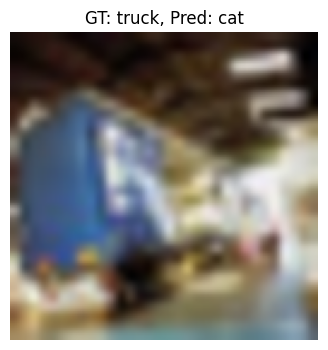

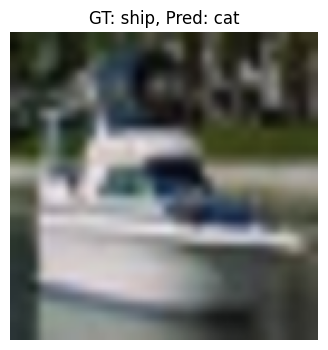

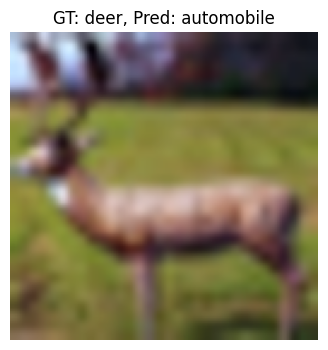

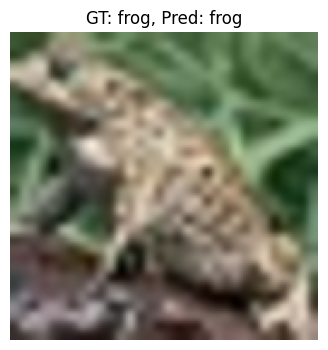

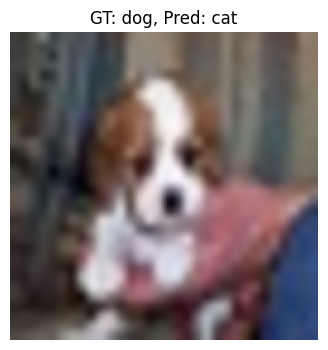

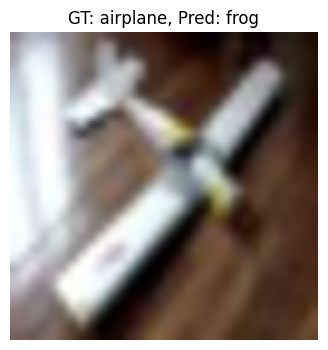

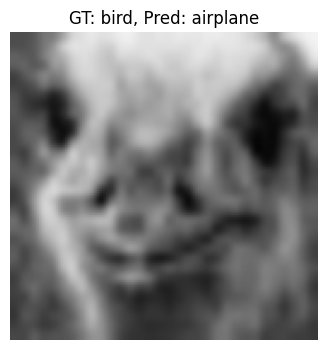

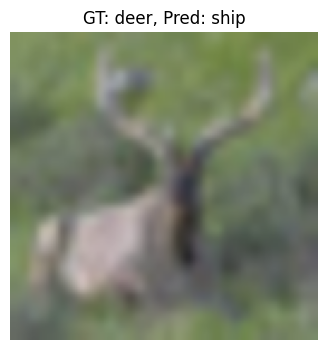

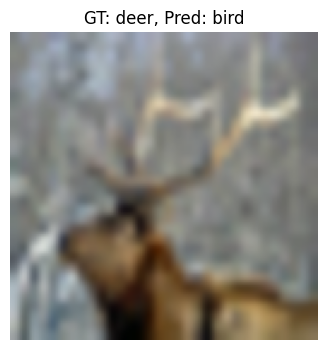

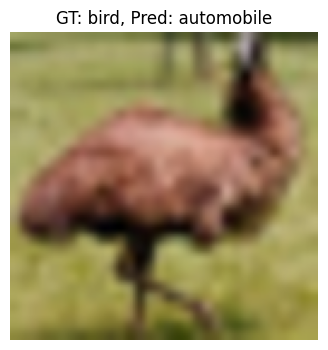

In [16]:
# --- Randomly visualize classification results on test images ---
import matplotlib.pyplot as plt
# CIFAR-10 类别名称
class_names = testset.classes
# 随机选取几张图
for idx in random.sample(range(len(testset)), 10):
    img_t, label = testset[idx]
    # Tensor [C,H,W] 转为 HxWxC uint8 图像
    img_np = (img_t.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    # 构建 BoVW 特征
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    kps = detect_interest_points(gray, method=INTEREST_METHOD)
    des = compute_custom_sift_descriptor(gray, kps)
    if des is None:
        hist = np.zeros(N_CLUSTERS, dtype=float)
    else:
        hist = build_bovw(des)
    # 标准化 & 预测
    # X = scaler.transform(hist.reshape(1, -1)) if 'scaler' in globals() else hist.reshape(1, -1)
    pred = best_model.predict(hist.reshape(1, -1))[0]
    # 可视化
    plt.figure(figsize=(4,4))
    plt.imshow(img_np)
    plt.title(f"GT: {class_names[label]}, Pred: {class_names[pred]}")
    plt.axis('off')
    plt.show()

In [17]:
# # 定义 SVM 管道并开启 verbose 打印收敛信息，关闭 shrinking 提速
# svm_fast = make_pipeline(
#     StandardScaler(),
#     LinearSVC(
#         penalty='l2',
#         loss='squared_hinge',  # 改成 squared_hinge
#         dual=False,            # n_samples > n_features 时推荐 False
#         max_iter=5000,
#         tol=1e-4,
#         verbose=1
#     )
# )

# # 在 train_feats / train_labels 上训练
# svm_fast.fit(train_feats, train_labels)
# print("SVM training complete.")

In [18]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # 1. 预测
# svm_preds = svm_fast.predict(test_feats)

# # 2. 整体准确率
# acc = accuracy_score(test_labels, svm_preds)
# print(f"SVM Test Accuracy: {acc:.4f}")

# # 3. 详细报告
# print(classification_report(test_labels, svm_preds))

# # 4. （可选）混淆矩阵
# cm = confusion_matrix(test_labels, svm_preds)
# print("Confusion Matrix:")
# print(cm)

## KNN


In [24]:
from sklearn.neighbors import KNeighborsClassifier


clf_knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
clf_knn.fit(train_feats, train_labels)
preds_knn = clf_knn.predict(test_feats)
acc_knn = accuracy_score(test_labels, preds_knn)
print(f"KNN Test Accuracy: {acc_knn:.4f}")

KNN Test Accuracy: 0.1010
